# Write annotation.json to .txt for mmseg

In [ ]:
import json

with open("/home/s/tuyenld/endoscopy/public_dataset.json") as f:
    data = json.load(f)

# Write to txt
data = data["train"]["images"]
data_new = []

for d in data:
    data_new.append(d.split("/")[-1].split(".")[0])

with open("../data/train_public_dataset.txt", "w+") as f:
    for d in data_new:
        f.write(d + "\n")

# Tensorboard

In [ ]:
!tensorboard --logdir=work_dirs

# Test Dataset, Dataloader, Data Preprocessor, Inferencer

### Test BGR to RGB

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
img = cv2.imread("/home/s/tuyenld/DATA/public_dataset/TrainDataset/image/cjyzu9th0qt4r0a46pyl4zik0.png")
plt.imshow(img)

In [ ]:
img_cv2_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv2_rgb)

### Test PIL Image

In [ ]:
img = Image.open("/home/s/tuyenld/DATA/public_dataset/TrainDataset/image/cjyzu9th0qt4r0a46pyl4zik0.png")
plt.imshow(img)

In [ ]:
img = Image.open("/home/s/tuyenld/DATA/public_dataset/TrainDataset/masks/cjyzu9th0qt4r0a46pyl4zik0.png")
plt.imshow(img)

In [ ]:
img_np = np.array(img)

In [ ]:
img_np.shape

In [ ]:
img_np

In [ ]:
plt.imshow(img_np)

In [ ]:
img = cv2.imread("/home/s/tuyenld/DATA/public_dataset/TrainDataset/image/1.png")
plt.imshow(img)

### Test DataLoader, Data Preprocessor

In [ ]:
from mmseg_custom.datasets.public_dataset import PublicDataset
from mmseg.models import SegDataPreProcessor
from mmengine.registry import init_default_scope
init_default_scope('mmseg')

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', scale=(512, 512), keep_ratio=False),
    # dict(type='PhotoMetricDistortion'),
    # dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512), keep_ratio=False),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='PackSegInputs')
]

train_dataset = PublicDataset(
                        # ann_file="../data/train_public_dataset.txt",
                    data_prefix=dict(
                        img_path="/home/s/tuyenld/DATA/public_dataset/TrainDataset/image", 
                        seg_map_path="/home/s/tuyenld/DATA/public_dataset/TrainDataset/masks"
                    ),
                    pipeline=train_pipeline
                )

test_dataset = PublicDataset(
                # ann_file="../data/test_CVC-ClinicDB.txt",
                    data_prefix=dict(
                        img_path='/home/s/tuyenld/DATA/public_dataset/TestDataset/CVC-ClinicDB/images',
                        seg_map_path='/home/s/tuyenld/DATA/public_dataset/TestDataset/CVC-ClinicDB/masks'
                    ),
                    pipeline=test_pipeline
                )

data_preprocessor = SegDataPreProcessor(
    # mean=[123.675, 116.28, 103.53],
    # std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    # rgb_to_bgr=True,
    size=(512,512)
)

#### Test Dataset

In [ ]:
print(train_dataset.get_data_info(0))
print(test_dataset.get_data_info(1))

In [ ]:
train_dataset[0]

In [ ]:
train_dataset[0]["inputs"].shape

In [ ]:
plt.imshow(train_dataset[0]["inputs"].permute(1,2,0))

In [ ]:
img_rgb = cv2.cvtColor(train_dataset[0]["inputs"].permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
gt = train_dataset[0]["data_samples"].gt_sem_seg.data

In [ ]:
gt = gt.squeeze(0)
plt.imshow(gt)

In [ ]:
gt.shape

In [ ]:
gt[400, 500]

In [ ]:
test_dataset[1]

In [ ]:
test_dataset[1]["inputs"].shape

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_dataset[1]["inputs"].permute(1,2,0))

In [ ]:
gt = test_dataset[1]["data_samples"].gt_sem_seg.data

In [ ]:
gt = gt.squeeze(0)
plt.imshow(gt)

In [ ]:
gt.shape

In [ ]:
import torch
# label = torch.load("label.pth").cpu()
# pred_label = torch.load("pred_label.pth").cpu()
# mask = torch.load("mask.pth").cpu()
# target = torch.load("target.pth").cpu()
# mask.shape, target.shape
valid_mask = torch.load("valid_mask.pth").cpu()
valid_mask.shape

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(valid_mask[1].squeeze(0))

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(target[1].squeeze(0))

#### Data Preprocessor

In [ ]:
data_procceed = data_preprocessor(train_dataset[0])

In [ ]:
data_procceed

In [ ]:
data_procceed["inputs"]

In [ ]:
data_procceed["inputs"].shape

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_procceed["inputs"].int().permute((1, 2, 0)))

### Test Inferencer

In [ ]:
test_dataset.get_data_info(17)

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

config = "configs/mae/mae-base_upernet_8xb2-amp-40k_publicdataset-512x512.py"
ckpt = "/home/s/tuyenld/mae/downstream/segmentation/work_dirs/mae-base_upernet_8xb2-amp-40k_publicdataset-512x512_exp7/iter_24000.pth"
# img_path = "/home/s/tuyenld/DATA/public_dataset/TestDataset/CVC-ClinicDB/images/25.png"
img_path = test_dataset.get_data_info(17)["img_path"]

model = init_model(config, ckpt, device='cuda:0')
result = inference_model(model, img_path)
result.gt_sem_seg = test_dataset[17]["data_samples"].gt_sem_seg

In [ ]:
print(len(test_dataset))

In [ ]:
model.dataset_meta

In [ ]:
vis_image = show_result_pyplot(model, img_path, result, show=False, save_dir='infer')

In [ ]:
result.keys()

In [ ]:
result.pred_sem_seg.data.shape

In [ ]:
pred_label = result.pred_sem_seg.data.cpu().squeeze()
label = result.gt_sem_seg.data.cpu().squeeze()

In [ ]:
import torch

intersect = pred_label[pred_label == label]
area_intersect = torch.histc(
    intersect.float(), bins=2, min=0,
    max=1).cpu()
area_pred_label = torch.histc(
    pred_label.float(), bins=2, min=0,
    max=1).cpu()
area_label = torch.histc(
    label.float(), bins=2, min=0,
    max=1).cpu()
area_union = area_pred_label + area_label - area_intersect

In [ ]:
intersect.sum(), area_intersect, area_union, area_pred_label, area_label

In [ ]:
results = (area_intersect, area_union, area_pred_label, area_label)

results = tuple(zip(*results))
assert len(results) == 4, "False"

In [ ]:
import numpy as np

true_positives = np.sum(np.round(np.clip(pred_label.numpy() * label.numpy(), 0, 1)))
intersection = true_positives
intersection

In [ ]:
union = np.sum(pred_label.numpy())+np.sum(label.numpy())-intersection
union

In [ ]:
predicted_positives = np.sum(np.round(np.clip(pred_label.numpy(), 0, 1)))
predicted_positives

In [ ]:
possible_positives = np.sum(np.round(np.clip(label.numpy(), 0, 1)))
possible_positives

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(result.pred_sem_seg.data.cpu().squeeze(0))

In [ ]:
result.seg_logits.data.squeeze(0)[60, 170]

### Test Dilation, Erosion, Opening, Closing

In [ ]:
test_result = result.pred_sem_seg.data.cpu().squeeze(0).numpy()

In [ ]:
test_result

In [ ]:
import cv2
import numpy as np

kernel = np.ones((51, 51), np.uint8)
closing = cv2.morphologyEx(test_result, cv2.MORPH_CLOSE, kernel, iterations=1) 
plt.imshow(closing)

# Test Load Net

In [ ]:
import torch

In [ ]:
state_dict = torch.load("/home/s/tuyenld/mae/downstream/segmentation/mae_pretrain_vit_base.pth")

In [ ]:
state_dict['model']["pos_embed"].shape

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=768):
        super(Net, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim), requires_grad=False)
    
    def init_weights(self):
        nn.init.normal_(self.pos_embed, std=0.02)

model = Net()
model.init_weights()
model_state_dict = model.state_dict()

In [ ]:
model_state_dict

In [ ]:
cls_token_weight = model.pos_embed[:, 0]
pos_embed_weight = model.pos_embed[:, (-1 * 14 * 14):]

In [ ]:
cls_token_weight.shape

In [ ]:
pos_embed_weight, pos_embed_weight.shape

In [ ]:
from mmseg.models.utils import resize
pos_embed_weight = pos_embed_weight.reshape(
    1, 14, 14, model.pos_embed.shape[2]).permute(0, 3, 1, 2)
pos_embed_weight = resize(
    pos_embed_weight, size=(32, 32), align_corners=False, mode='bicubic')

In [ ]:
pos_embed_weight

In [ ]:
pos_embed_weight.shape

In [ ]:
pos_embed_weight = torch.flatten(pos_embed_weight, 2)

In [ ]:
pos_embed_weight.shape

# Model High Resolution

In [ ]:
model_high_resolution = Net(img_size=512, patch_size=16, embed_dim=768)

In [ ]:
model_high_resolution.pos_embed.shape != model.pos_embed.shape

In [ ]:
model_high_resolution.load_state_dict(model_state_dict, False)
model_high_resolution_state_dict = model_high_resolution.state_dict()

In [ ]:
from mmengine.config import Config

cfg = Config.fromfile('/home/s/tuyenld/mae/downstream/segmentation/configs/mae/mae-base_upernet_8xb2-amp-160k_publicdataset-512x512.py')
print(cfg)

# Model Info

In [ ]:
from mmseg_custom.models.backbones.mae import MaskedAutoencoderViT
from mmengine.analysis import get_model_complexity_info

input_shape = (3, 224, 224)
model = MaskedAutoencoderViT(out_indices=[3, 5, 7, 11])
analysis = get_model_complexity_info(model, input_shape)
analysis

In [ ]:
print(analysis["out_table"])

In [ ]:
print(analysis["out_arch"])

# Test

In [ ]:
from mmseg.utils.collect_env import collect_env
collect_env()

In [ ]:
# import mmseg_custom
from mmseg.registry import MODELS, DATASETS, METRICS, EVALUATOR

In [ ]:
import mmseg_custom
print(MODELS.module_dict)
print(DATASETS.module_dict)
print(METRICS.module_dict)

In [ ]:
METRICS

In [ ]:
from mmengine.config import Config

config = Config.fromfile("/home/s/tuyenld/mae/downstream/segmentation/configs/mae/mae-base_upernet_8xb2-amp-160k_publicdataset-512x512.py")

In [ ]:
config

In [ ]:
import os
len(os.listdir("/home/s/tuyenld/DATA/public_dataset/TrainDataset/image"))

In [ ]:
import json

with open("/home/s/tuyenld/endoscopy/public_dataset.json") as f:
    data = json.load(f)

for key in data["test"].keys():
    # print(len(data["test"][key]["images"]))
    with open(f"../data/test_{key}.txt", "w+") as f:
        for d in data["test"][key]["images"]:
            f.write(d.split("/")[-1].split(".")[0] + "\n")

In [ ]:
import numpy as np
from mmcv.transforms import Resize

transform = Resize((2048, 512))
data_dict = {'img': np.random.rand(512, 1024, 3)}
data_dict = transform(data_dict)
print(data_dict['img'].shape)

In [ ]:
!tensorboard --logdir=/home/s/tuyenld/mae/downstream/segmentation/work_dirs

In [ ]:
import torch

results = torch.load("results.pth")
results_collect = torch.load("results_collect.pth")

In [ ]:
results[53]

In [ ]:
results_collect

In [ ]:
# area_intersect, area_union, area_pred_label, area_label
test = [([2,3], [4,5], [6,7], [8, 9]),
        ([-2, -3], [-4, -5], [-6, -7], [-8, -9])]

test = tuple(zip(*test))
test, len(test)

In [ ]:
results = tuple(zip(*results))

In [ ]:
total_area_intersect = sum(results[0])
total_area_union = sum(results[1])
total_area_pred_label = sum(results[2])
total_area_label = sum(results[3])

In [ ]:
total_area_intersect, total_area_union, total_area_pred_label, total_area_label

In [ ]:
from prettytable import PrettyTable
columns = ["Student Name", "Class", "Section", "Percentage"] 
myTable = PrettyTable() 
  
# Add Columns 
myTable.add_column(columns[0], 76)
print(myTable)

In [ ]:
import torch
import torch.nn as nn

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        # assert H == self.img_size[0] and W == self.img_size[1], \
        #     f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        Hp, Wp = x.shape[2], x.shape[3]
        
        x = x.flatten(2).transpose(1, 2)
        return x, Hp, Wp

In [ ]:
PatchEmbed()(torch.randn(1, 3, 352, 352))

In [ ]:
import torch
from timm.layers import PatchEmbed, PatchEmbedWithSize, resample_abs_pos_embed

patch_embed = PatchEmbed(strict_img_size=False)

output = patch_embed(torch.randn(1, 3, 512, 512))
output

In [ ]:
patch_embed_w = patch_embed.proj.weight

In [ ]:
patch_embed_w.shape

In [ ]:
pos_embed = torch.nn.Parameter(torch.randn(1, 197, 768), requires_grad=False)

In [ ]:
pos_embed.shape

In [ ]:
new_pos_embed = resample_abs_pos_embed(pos_embed, (32, 32), (14, 14))

In [ ]:
new_pos_embed.shape

In [1]:
from mmseg_custom import MAEAdapter
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/home/kc/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = MAEAdapter(
  drop_path_rate=0.3, 
  init_values=1e-6, 
  deform_num_heads=16,
  deform_ratio=1.0, 
  with_cp=True,  # set with_cp=True to save memory
  interaction_indexes=[[0, 5], [6, 11], [12, 17], [18, 23]],
  use_vit_adapter=True,
  num_register_tokens=4,
).cuda()

Using 4 register tokens


/mnt/tuyenld/mae/downstream/segmentation/ops/deformable_attention/modules/ms_deform_attn.py:45: UserWarning: You'd better set d_model in MSDeformAttn to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(


In [3]:
import torch
import math

for i in range(999999999999999999):
  for j in range(725):
    output = model(torch.randn(8, 3, 352, 352).cuda())

/mnt/miniconda3/envs/vit_adapter/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: 

In [1]:
from mmengine.runner import Runner
from mmengine.config import Config
import os
os.environ['LOCAL_RANK'] = "0"

cfg = Config.fromfile('/mnt/tuyenld/mae/downstream/segmentation/configs/mae/mae_base_adapter.py')

/home/kc/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg.launcher = 'none'
cfg.work_dir = os.path.join("./test", "abc")
cfg.resume = False

runner = Runner.from_cfg(cfg)

06/10 13:49:23 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 292677518
    GPU 0,1: NVIDIA GeForce RTX 3090
    CUDA_HOME: /mnt/miniconda3/envs/vit_adapter
    NVCC: Cuda compilation tools, release 11.7, V11.7.64
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.0.0+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=com

/mnt/tuyenld/mae/downstream/segmentation/ops/deformable_attention/modules/ms_deform_attn.py:45: UserWarning: You'd better set d_model in MSDeformAttn to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(
/mnt/miniconda3/envs/vit_adapter/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:136: UserWarning: threshold is not defined for binary, and defaultsto 0.3
  warnings.warn('threshold is not defined for binary, and defaults'
/mnt/miniconda3/envs/vit_adapter/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '


06/10 13:49:28 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/10 13:49:28 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/mnt/miniconda3/envs/vit_adapter/lib/python3.10/site-packages/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [28]:
train_data = runner.train_dataloader.dataset[0]
train_data["inputs"].shape

torch.Size([3, 352, 352])

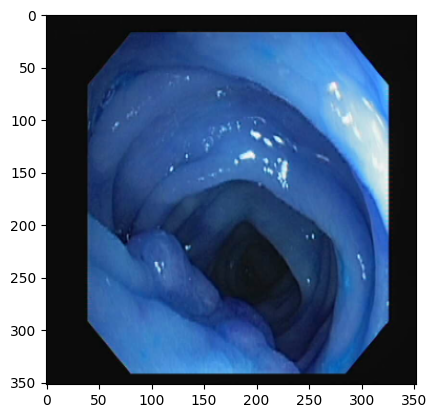

In [26]:
import matplotlib.pyplot as plt

plt.imshow(train_data["inputs"].permute(1,2,0))

In [29]:
train_data["data_samples"].gt_sem_seg.data.shape

torch.Size([1, 352, 352])

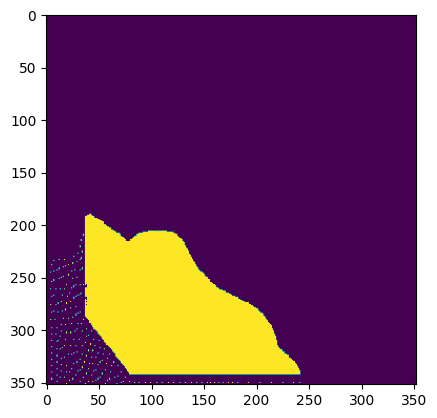

In [27]:
plt.imshow(train_data["data_samples"].gt_sem_seg.data.squeeze(0))

In [3]:
val_data = next(iter(runner.val_dataloader))

/mnt/miniconda3/envs/vit_adapter/lib/python3.10/site-packages/mmseg/datasets/transforms/loading.py:83: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


In [12]:
val_data.keys()

dict_keys(['inputs', 'data_samples'])

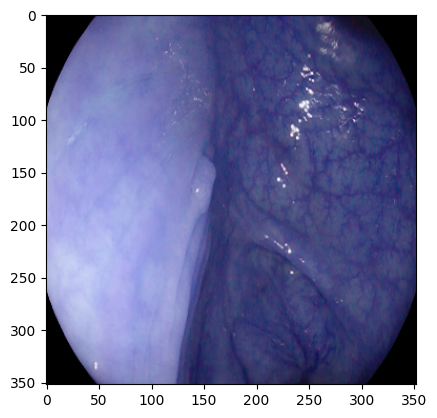

In [4]:
import matplotlib.pyplot as plt

plt.imshow(val_data["inputs"][0].permute(1,2,0))

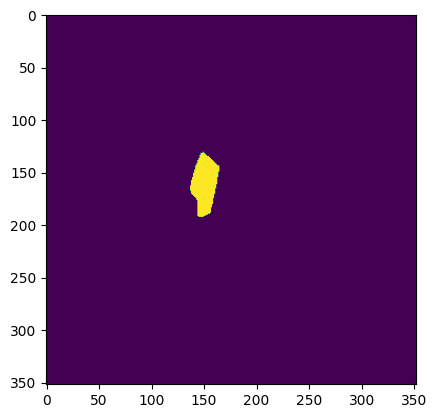

In [5]:
plt.imshow(val_data["data_samples"][0].gt_sem_seg.data.squeeze(0))

In [10]:
from PIL import Image
import numpy as np

img = Image.open("/mnt/tuyenld/mae/downstream/segmentation/eval_results/5.png")
img = np.array(img)

In [11]:
img = img*255